(reservoir-dynamic-level-limit)=
# Reservoir dynamic level limit

This example illustrates how the [reservoir](reservoir) dynamic level limit constraint works. The dynamic level constraints imposes a maximum deviation between the lowest and highest reservoir [level](reservoir:head) within predefined time periods (e.g. max 15 cm deviation within each 24 hours in the optimization period). The constraints are similar to the reservoir limit level period ramping ([limit_level_period_ramping_up](reservoir:limit_level_period_ramping_up) and [limit_level_period_ramping_down](reservoir:limit_level_period_ramping_down)), except the constraint is on the maximum level difference within each time period instead of the maximum difference between consecutive time periods. 

The model setup for this example is available in the following format:
- pyshop
    - [rsv_dynamic_level_limit.py](rsv_dynamic_level_limit.py)

In [1]:
#Necessary imports 
import pandas as pd
import plotly.offline as py
import plotly.graph_objs as go
py.offline.init_notebook_mode(connected=True)
from pyshop import ShopSession

#Functions used in this example for building a basic SHOP model and running it, and for plotting the results
from rsv_dynamic_level_limit import build_model, run_model, plot_period_levels

## Create SHOP session and import basic model

Our example model consists of one reservoir and one plant.

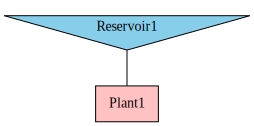

In [2]:
#Create a standard ShopSession
shop=ShopSession()
#Build a basic SHOP model
build_model(shop)

#Display topology to the screen
display(shop.model.build_connection_tree())

## Run model without dynamic level constraints

We ultimately want to impose a maximum of 40 cm deviation between min and max reservoir level within every consecutive four hour period of the optimization. In addition, the first four hour period started two hours before the start of our SHOP optimization. The reservoir level in the two hours before start is known to be 94.6 and 95 masl:

In [3]:
interval_length = 4*60   # Length of periods in minutes
offset = 2*60            # Start time of the first whole 4 hour period relative to the start time (minutes)

#get optimization start time
starttime = shop.get_time_resolution()['starttime']
# Historical reservoir level from measurements
historical_level = pd.Series([94.6,95.0], index=[starttime - pd.Timedelta(hours = 2), starttime - pd.Timedelta(hours=1)])

We start by running our model without any dynamic level limit constraints.

In [4]:
run_model(shop)

We then plot the resulting reservoir level, and we see that the level variation is more than 0.4 m within all of the time periods. Note that the historical_level attribute is ignored in this initial run but is used for plotting purposes.

In [5]:
rsv = shop.model.reservoir["Reservoir1"]
rsv.historical_level.set(historical_level)
lrl = rsv.lrl.get()

plot_period_levels(starttime, rsv, offset, interval_length, lrl, "Optimization without dynamic level limit constraints")

## Add dynamic level limit constraints

We will now create a new SHOP instance and add the [dynamic_level_limit](reservoir:dynamic_level_limit) constraints. We define our fixed time periods to be four hours long, with an [offset](reservoir:dynamic_level_limit_offset) of two hours. The offset means that the first whole time period will start two hours after the start of the optimization period. The two initial hours are therefore part of a partially historic period that includes the two hours before optimization start. To ensure that the constraint is enforced correctly for this first period, historical reservoir level data must be provided through the reservoir attribute [historical_level](reservoir:historical_level).

It is possible to define multiple dynamic reservoir limits with different period lengths (e.g. 40 cm over four hours and 100 cm over 168 hours) by adding more entries into each XY table in the dynamic_level_limit XYT. The time stamps in the XYT also makes it possible to change the constraint limits inside the optimization period, such as changing the four hour limit from 40 cm to 20 cm after 12 hours. This type of modelling is not shown in this example.

In [6]:
shop2 = ShopSession()
build_model(shop2)

#set historical reservoir level
shop.model.reservoir.Reservoir1.historical_level.set(historical_level)

# 40 cm deviation limit
limit = 0.4       

#set dynamic level limit and offset
dynamic_level_limit= [pd.Series(data=[limit], index=[interval_length], name=pd.Timestamp(starttime + pd.Timedelta(hours=0)))]
dynamic_level_limit_offset = pd.Series(index=[starttime + pd.Timedelta(minutes=offset)], data=[interval_length])

rsv = shop2.model.reservoir.Reservoir1
rsv.dynamic_level_limit.set(dynamic_level_limit)
rsv.dynamic_level_limit_offset.set(dynamic_level_limit_offset)

#set historical reservoir level data
rsv.historical_level.set(pd.Series([94.6,95.0], index=[starttime - pd.Timedelta(minutes = interval_length - offset), starttime - pd.Timedelta(hours=1)]))

#run model
run_model(shop2)

Again we plot the resulting reservoir levels. We see that now the level variation is equal to the maximum allowed value of 0.4 m within all of the time periods, including the very first time period for which the historical data is used.

In [7]:
plot_period_levels(starttime, rsv, offset, interval_length, lrl, "Optimization with dynamic level limit constraints")

Note that the final constraint period only contains two time steps within the optimization, since the total horizon is 24 hours long and an offset of two hours is used. The dynamic level limit constraint is still enforced on this final two hour long period.